In [1]:
import numpy as np
import rdkit as rd
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.DataStructs.cDataStructs import TanimotoSimilarity

In [2]:
#Determines if SMILES is valid or not
def is_valid(smiles):
    
    mol = Chem.MolFromSmiles(smiles)

    #Returns True if SMILES is valid, returns False if SMILES is invalid
    return smiles != '' and mol is not None and mol.GetNumAtoms() > 0

In [3]:
#Determines LogP
def logP(smiles):
    
    return(Descriptors.MolLogP(Chem.MolFromSmiles(smiles)))

In [4]:
#Determins molecular weight
def molWt(smiles):
    
    return(Descriptors.MolWt(Chem.MolFromSmiles(smiles)))

In [5]:
#Determine number hydrogen bond acceptors
def numAcc(smiles):
    
    return(Descriptors.NumHAcceptors(Chem.MolFromSmiles(smiles)))

In [6]:
#Determine number hydrogen bond donors
def numDon(smiles):
    
    return(Descriptors.NumHDonors(Chem.MolFromSmiles(smiles)))

In [7]:
#Determine polar surface area
def polSur(smiles):
    
    return(Descriptors.TPSA(Chem.MolFromSmiles(smiles)))

In [8]:
#Determine number of rotatable bonds
def rolBon(smiles):
    return(Descriptors.NumRotatableBonds(Chem.MolFromSmiles(smiles)))

In [9]:
#Number of characters generated
num_characters = 0

#Number of molecules generated
num_smiles = 0

#Number of unique SMILES
num_unq_mols = 0

#Number of unique SMILES that aren't in the training data
num_mols = 0

#Number of valid molecules that aren't in the training data generated
num_valid = 0

#List of smiles in file, to make sure smiles are unique
smileslist = []

In [10]:
#Test how many molecules are valid (without considering uniqueness, novelty)
total = 0
number_valid = 0

#Read in data file line by line
for line in open("gen.txt", "r"):
    total += 1
    
    #Ensure smiles are valid
    if(is_valid(line) == True):
                           
        #Increment number of valid molecules generated
        number_valid += 1

print("Percent valid molecules: " + str(number_valid / total * 100))

Percent valid molecules: 77.29439204948788


In [11]:
#Training data
training_data = list(open("smiles.txt", "r"))

#File with unique generated SMILES that aren't in the training data
generatedmols = open("genmols.txt", "w")

#Read in data file line by line
for line in open("gen.txt", "r"):
    
    #Ensure molecules are unique
    if line not in smileslist:
        
        smileslist.append(line)
        
        num_unq_mols += 1

        #Ensure smiles aren't in training data
        if line not in training_data:  

            #Remove \n character, remove G character
            smiles = line.replace("\n", "").replace("G", "")
            
            #Increment number of molecules generated
            num_mols += 1

            #Ensure smiles are valid
            if(is_valid(smiles) == True):
            
                #Copy over SMILES satisfying requirements
                generatedmols.write(smiles + "\n")
                
                #Increment number of valid molecules generated
                num_valid += 1
                
    #Increment total number of SMILES generated
    num_smiles += 1
    
    #Add length of line to total number of characters
    num_characters += len(line)

In [12]:
print("Number of characters generated: " + str(num_characters))
print("Number of molecules generated: " + str(num_smiles))
print("Number of unique molecules generated: " + str(num_unq_mols))
print("Number of novel and unique molecules generated: " + str(num_mols))
print("Number of novel, unique, and valid molecules generated: " + str(num_valid))

Number of characters generated: 980282
Number of molecules generated: 19722
Number of unique molecules generated: 13427
Number of novel and unique molecules generated: 13427
Number of novel, unique, and valid molecules generated: 9415


In [13]:
#List of Morgan fingerprints of molecules
fingerprints = []

#Read in data file line by line
for line in open("genmols.txt", "r"):
    
    #Convert SMILES string to Morgan fingerprint
    mol = Chem.MolFromSmiles(line.replace("\n", ""))
    fingerprint = AllChem.GetMorganFingerprint(mol, 2)
    
    #Add to list of fingerprints
    fingerprints.append(fingerprint)

In [14]:
import random

#Total Tanimoto Distance
tanimoto = 0

nummols = 1000
randfings = random.sample(fingerprints, nummols)

#Calculate Tanimoto Distance between each pair of fingerprints
for fpt1 in randfings:
    for fpt2 in randfings:
        
        if fpt1 != fpt2:
            
            #Calculate Tanimoto Similarity
            tan = TanimotoSimilarity(fpt1, fpt2)
            tanimoto += tan

#Average Tanimoto Similarity
avg_tanimoto = (1 / (nummols * (nummols - 1))) * tanimoto
print("Average Tanimoto Similarity: {:0.4f}".format(avg_tanimoto))

Average Tanimoto Similarity: 0.1587


In [71]:
#Array of molecular properties for generated molecules
molprops = np.empty((0,5))

fgenmols = open("fgenmols.txt", "w")

#Read in data file line by line
for molecule in open("genmols.txt", "r"):
    try:
        #Array of properties [partition coefficient, molecular weight, number of hydrogen bond acceptors, number of hydrogen bond donors, number of rotatable bonds]
        props = np.reshape(np.array([logP(molecule), molWt(molecule), numAcc(molecule), numDon(molecule), rolBon(molecule)]), (1, 5))
    
        #Append properties
        molprops = np.append(molprops, props, axis=0)
        
        #Write molecules to final, cleaned dataset
        fgenmols.write(molecule)
        
    except: 
        #Occasionally RDKit bugs don't allow for analyzing the molecule; in these cases, do not include the molecule in the final dataset
        continue
        
fgenmols.close()

In [73]:
#Array of number of molecules each molecule is dominated by
dom = np.zeros((np.shape(molprops)[0]))

#Analyze each molecule's properties as they compare to others
for i in range(np.shape(molprops)[0]):
    
    for j in range(np.shape(molprops)[0]):
        #Compare each property between the molecules
        if (molprops[j, 0] <= molprops[i, 0]):
            
            if (molprops[j, 1] <= molprops[i, 1]):
            
                if (molprops[j, 2] <= molprops[i, 2]):

                    if (molprops[j, 3] <= molprops[i, 3]):
            
                       if (molprops[j, 4] <= molprops[i, 4]):
                            
                            #if molecule j is better than molecule i in every property, than j dominates i
                            dom[i] += 1

In [74]:
#Fraction of molecules to be selected
top = 0.5

#Select the best of the molecules
finestmols = np.argpartition(dom, int(top * (np.shape(molprops)[0])))
finestmols = finestmols[:int(top * (np.shape(molprops)[0]))]

In [75]:
#Save best molecules to transferdata.txt
transferdata = open("transferdata.txt", "w")

i = 0
for line in open("fgenmols.txt", "r"):
    if i in finestmols:
        #Append start token
        line = line.rjust(len(line)+1, "G")
        
        #Write to file
        transferdata.write(line)
    
    i += 1 

transferdata.close()

In [76]:
#Array of molecular properties for generated molecules
transferMolProps = np.empty((0,5))

#Read in data file line by line
for molecule in open("transferdata.txt", "r"):
    
    #Remove start token to analyze molecules
    molecule = molecule.replace("G", "")
    
    try:
        #Array of properties [partition coefficient, molecular weight, number of hydrogen bond acceptors, number of hydrogen bond donors, number of rotatable bonds]
        transferProp = np.reshape(np.array([logP(molecule), molWt(molecule), numAcc(molecule), numDon(molecule), rolBon(molecule)]), (1, 5))
    
        #Append properties
        transferMolProps = np.append(transferMolProps, transferProp, axis=0)
    
    except:
        #Occasionally RDKit bugs don't allow for analyzing the molecule; in these cases, simply remove the molecule
        molecule.replace(molecule, "")
        continue

In [83]:
#PCA visualization
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA
printmols = np.concatenate((molprops, transferMolProps), axis=0)
#Scale array of properties for all molecules
scaledProps = StandardScaler().fit_transform(printmols)

#Apply PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(scaledProps)

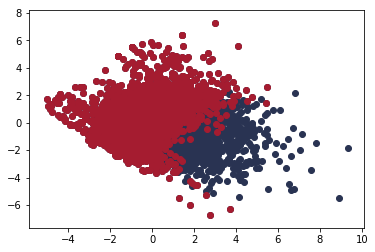

In [84]:
#Graph
import matplotlib.pyplot as plt

fig = plt.figure()
plt.scatter(principalComponents[0:np.shape(molprops)[0],0],principalComponents[0:np.shape(molprops)[0],1], color = "#293352")
plt.scatter(principalComponents[np.shape(molprops)[0]:,0],principalComponents[np.shape(molprops)[0]:,1], color = "#A51C30")
plt.show(fig)

In [32]:
print(np.shape(transferMolProps))

(4674, 5)
